In [2]:
import pandas as pd
import numpy as np

import json
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import random
import string 
import re
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# 1. MSCOCO Train Dataset

In [3]:
# Convert .josn file to .csv
mscoco_train2014_que = json.load(open(f'0Data/MSCOCO/Que/v2_OpenEnded_mscoco_train2014_questions.json','r'))
mscoco_train2014_ans = json.load(open(f'0Data/MSCOCO/Ans/v2_mscoco_train2014_annotations.json','r'))

mscoco_train2014_que_df = pd.DataFrame(mscoco_train2014_que['questions'])
mscoco_train2014_ans_df = pd.DataFrame(mscoco_train2014_ans['annotations'])

mscoco_train2014 = pd.merge(mscoco_train2014_que_df, mscoco_train2014_ans_df, on=["image_id", "question_id"])

cols = ['image_id','question_id','question','question_type','multiple_choice_answer','answers','answer_type']
mscoco_train2014 = mscoco_train2014[cols]


#convert image_id to image_path
def image_id_to_path(subset,image_id):
    imdir='%s/COCO_%s_%012d.jpg'
    image_path = imdir%(subset, subset, image_id)
    return image_path

subset = 'train2014'
image_path = []
for i in (range(len(mscoco_train2014))):
    image_path.append(image_id_to_path(subset,mscoco_train2014['image_id'][i]))
mscoco_train2014['image_id'] = image_path


# create a list of multiple answers of an question
answers_list = []
for i in (range(len(mscoco_train2014))):
    ans_list = []
    for dic in (mscoco_train2014['answers'][i]):
        ans_list.append(dic['answer'])
    answers_list.append(ans_list)
mscoco_train2014['answers'] = answers_list

# save dataframe to .csv
# mscoco_train2014.to_csv("0Data/mscoco_train2014.csv",index=False)

# mscoco_train2014 = pd.read_csv("0Data/mscoco_train2014.csv")
print('Number of Question & Answer in MSCOCO Train Dataset:',len(mscoco_train2014))
mscoco_train2014.head(5)

Number of Question & Answer in MSCOCO Train Dataset: 443757


,image_id,question_id,question,question_type,multiple_choice_answer,answers,answer_type
0,train2014/COCO_train2014_000000458752.jpg,458752000,What is this photo taken looking through?,what is this,net,"[net, net, net, netting, net, net, mesh, net, ...",other
1,train2014/COCO_train2014_000000458752.jpg,458752001,What position is this man playing?,what,pitcher,"[pitcher, catcher, pitcher, pitcher, pitcher, ...",other
2,train2014/COCO_train2014_000000458752.jpg,458752002,What color is the players shirt?,what color is the,orange,"[orange, orange, orange, orange, orange, orang...",other
3,train2014/COCO_train2014_000000458752.jpg,458752003,Is this man a professional baseball player?,is this,yes,"[yes, yes, yes, yes, yes, no, yes, yes, yes, yes]",yes/no
4,train2014/COCO_train2014_000000262146.jpg,262146000,What color is the snow?,what color is the,white,"[white, white, white, white, white, white, whi...",other


In [3]:
mscoco_path = "0Data/MSCOCO/Image/"
image_path = list(mscoco_train2014['image_id'])
question = list(mscoco_train2014['question'])
answer = list(mscoco_train2014['multiple_choice_answer'])

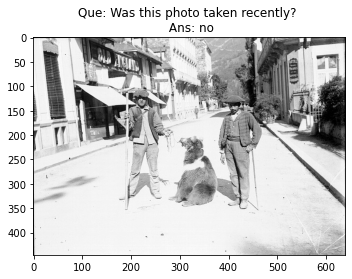

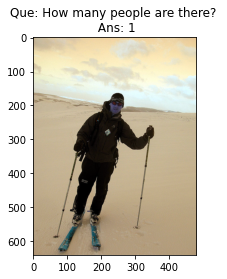

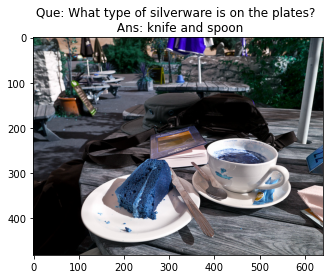

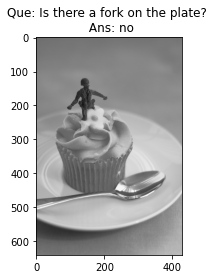

In [3]:
# Plot sample images, questions and answers
temp = random.sample(range(0, 1000), 4)
for a,i in enumerate(temp):
    image = cv2.imread(mscoco_path+image_path[i])
    plt.figure()
    plt.title(f'Que: {question[i]} \n Ans: {answer[i]}')
    plt.imshow(image)

**Observations:**
* We can see that the shapes of all the images are different, so need to analyze the shape of all the images and plot them.
* Most of the questions are simple and have clean text but some questions contain common word contractions like what's, it's, they're, etc, and noun contractions like guy's, man's, dog's, etc., and few words contain quotes, eg: "Merry", etc.
* Most of the answers are simple one word or numeric and clean text but some answers contain punctuations.

In [4]:
# Find the punctuations present in question and answer dataset
def find_punctuation(text):
    punctuation_list = []
    for t in text:
        for i in t:
            if i in string.punctuation:  
                punctuation_list.append(i)
    punctuation_list = list(set(punctuation_list))
    return punctuation_list

que_punct_list = find_punctuation(question)
ans_punct_list = find_punctuation(answer)
print(f'{len(que_punct_list)} punctuations found in the Question Dataset:\n{que_punct_list}')
print('-'*100)
print(f'{len(ans_punct_list)} punctuations found in the Answer Dataset:\n{ans_punct_list}')

21 punctuations found in the Question Dataset:
['&', "'", '^', ')', '*', '#', ',', '?', '(', '`', '_', '+', '.', '"', '%', '$', ';', '!', ':', '/', '-']
----------------------------------------------------------------------------------------------------
20 punctuations found in the Answer Dataset:
['&', "'", ')', '*', '#', ',', '/', '(', '_', '+', '.', '"', '@', '%', '$', ';', '!', ':', '?', '-']


**Observations:**
* Above is a list of 21 punctuations found in the question dataset and 20 punctuations found in the answer dataset.
* Hence, we need to perform data cleaning operation on question and answer dataset before EDA.
* In this problem, we will consider answers as multiple classes and consider this problem as a multi-class classification problem.

In [6]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    
    phrase = re.sub(r"he\'s", "he is", phrase)
    phrase = re.sub(r"she\'s", "she is", phrase)
    phrase = re.sub(r"it\'s", "it is", phrase)
    
    phrase = re.sub(r"he\’s", "he is", phrase)
    phrase = re.sub(r"she\’s", "she is", phrase)
    phrase = re.sub(r"it\’s", "it is", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase


def text_preprocess(text):
    text = text.lower()
    text = decontractions(text) # replace contractions into natural form
    text = re.sub('[-,:]', ' ', text) # replace the character "-" "," with space
    text = re.sub("(?!<=\d)(\.)(?!\d)", '', text) # remove the character ".", except from floating numbers
    text = re.sub('[^A-Za-z0-9. ]+', '', text) # remove all punctuation, except A-Za-z0-9 
    text = re.sub(' +', ' ', text) # remove extra space
    return text

def text_preprocess_ans(text):
    text = text.lower()
    text = decontractions(text) # replace contractions into natural form
    text = re.sub('[-,:]', ' ', text) # replace the character "-" "," with space
    text = re.sub("(?!<=\d)(\.)(?!\d)", '', text) # remove the character ".", except from floating numbers
    text = re.sub('[^A-Za-z0-9.! ]+', '', text) # remove all punctuation, except A-Za-z0-9 
    text = re.sub(' +', ' ', text) # remove extra space
    return text

In [6]:
# Question and Answer text preprocessing
mscoco_train2014["question_preprocessed"] = mscoco_train2014["question"].map(lambda x: text_preprocess(x))
mscoco_train2014["answer_preprocessed"] = mscoco_train2014["multiple_choice_answer"].map(lambda x: text_preprocess_ans(x))

In [7]:
# Sample Questions and Answers Befor and after text preprocessing
temp = random.sample(range(0, len(mscoco_train2014)), 4)
for i in temp:
    print(f'Que: {mscoco_train2014["question"][i]}\nAns: {mscoco_train2014["multiple_choice_answer"][i]}')
print('-'*50)
for i in temp:
    print(f'Que: {mscoco_train2014["question_preprocessed"][i]}\nAns: {mscoco_train2014["answer_preprocessed"][i]}')

Que: What is missing on the wall?
Ans: mirror
Que: Does the store sell kites?
Ans: no
Que: What is he on?
Ans: sidewalk
Que: What is the name of this room?
Ans: bathroom
--------------------------------------------------
Que: what is missing on the wall
Ans: mirror
Que: does the store sell kites
Ans: no
Que: what is he on
Ans: sidewalk
Que: what is the name of this room
Ans: bathroom


* We can see that all the punctuation present in questions and answers are removed and the word contractions are also replaced with their expanded form. 

In [8]:
mscoco_train2014 = mscoco_train2014.drop(['question', 'multiple_choice_answer'], axis=1)

cols = ['image_id','question_id','question_preprocessed','question_type','answer_preprocessed','answers','answer_type']
mscoco_train2014 = mscoco_train2014[cols]

# save dataframe to .csv
# mscoco_train2014.to_csv("0Data/mscoco_train2014_preprocessed.csv",index=False)

# mscoco_train2014 = pd.read_csv("0Data/mscoco_train2014_preprocessed.csv")
print('Number of Question & Answer in MSCOCO Train Dataset:',len(mscoco_train2014))
mscoco_train2014.head(2)

Number of Question & Answer in MSCOCO Train Dataset: 443757


,image_id,question_id,question_preprocessed,question_type,answer_preprocessed,answers,answer_type
0,train2014/COCO_train2014_000000458752.jpg,458752000,what is this photo taken looking through,what is this,net,"['net', 'net', 'net', 'netting', 'net', 'net',...",other
1,train2014/COCO_train2014_000000458752.jpg,458752001,what position is this man playing,what,pitcher,"['pitcher', 'catcher', 'pitcher', 'pitcher', '...",other


In [9]:
image_path = list(mscoco_train2014['image_id'])
question_preprocessed = list(mscoco_train2014['question_preprocessed'])
answer_preprocessed = list(mscoco_train2014['answer_preprocessed'])
question_type = list(mscoco_train2014['question_type'])
answer_type = list(mscoco_train2014['answer_type'])

## 1.1 EDA - Image

In [11]:
# Calculate Image shape
image_shape = []
for i in tqdm(range(len(mscoco_train2014))):
    image = cv2.imread(mscoco_path+image_path[i])
    image_shape.append(image.shape)

100%|█████████████████████████████████████████████████████████████████████████| 443757/443757 [35:40<00:00, 207.31it/s]


In [12]:
height = list((list(zip(*image_shape)))[0])
width = list((list(zip(*image_shape)))[1])
channel = list((list(zip(*image_shape)))[2])

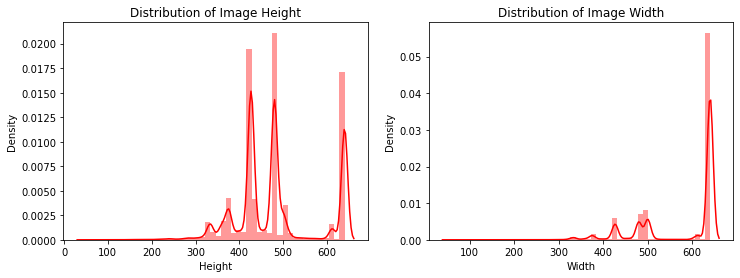

In [15]:
# Plot Distribution Image Height and Width
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(height, color='red')
plt.title('Distribution of Image Height')
plt.xlabel('Height')
plt.subplot(1,2,2)
sns.distplot(width, color='red')
plt.title('Distribution of Image Width')
plt.xlabel('Width')
plt.show()

In [16]:
print(f"Maximum Height: {max(height)}  Maximum Width: {max(width)}")
print(f"Minimum Height: {min(height)}  Minimum Width: {min(width)}")
print(f"Mean Height: {np.round(np.mean(height),2)}  Mean Width: {np.round(np.mean(width),2)}")
print(f"All the Images have same channel depth of {list(set(channel))[0]}.")

Maximum Height: 640  Maximum Width: 640
Minimum Height: 51  Minimum Width: 59
Mean Height: 482.51  Mean Width: 580.63
All the Images have same channel depth of 3.


**Observations:**
* All the images have different heights and widths, so need to reshape them in a similar height and width before further process.
* All the images have the same channel depth of 3 means they all are color(RGB) images. 

## 1.2 EDA - Question

In [10]:
# Create list of Character count, Word count, First one word, First two words, and unique words of questions 
char_count_que = []
word_count_que = []
first_word_que = []
two_word_que = []
unique_word_que = []

for q in question_preprocessed:
    char_count_que.append(len(q))
    word_count_que.append(len(q.split()))
    first_word_que.append(q.split()[0].lower())
    two_word_que.append(" ".join(q.split()[:2]).lower())
    unique_word_que.extend(q.split())
unique_word_que = set(unique_word_que)

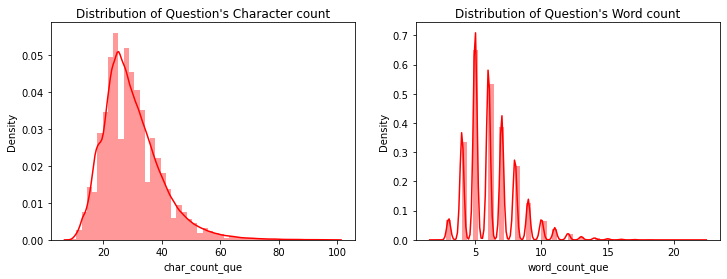

In [11]:
# Plot Distribution of Character count, Word count of question
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(char_count_que, color='red')
plt.title('Distribution of Question\'s Character count')
plt.xlabel('char_count_que')
plt.subplot(1,2,2)
sns.distplot(word_count_que, color='red')
plt.title('Distribution of Question\'s Word count')
plt.xlabel('word_count_que')
plt.show()

In [12]:
# Percentile of word_count_que
for i in range(0,101,10):
    print(f"{i}th percentile {np.percentile(word_count_que,i)}")
print("-"*25)
for i in range(91,101,1):
    print(f"{i}th percentile {np.percentile(word_count_que,i)}")

0th percentile 2.0
10th percentile 4.0
20th percentile 5.0
30th percentile 5.0
40th percentile 5.0
50th percentile 6.0
60th percentile 6.0
70th percentile 7.0
80th percentile 8.0
90th percentile 9.0
100th percentile 22.0
-------------------------
91th percentile 9.0
92th percentile 9.0
93th percentile 9.0
94th percentile 9.0
95th percentile 10.0
96th percentile 10.0
97th percentile 11.0
98th percentile 11.0
99th percentile 12.0
100th percentile 22.0


In [14]:
print("The maximum character length of Question:", max(char_count_que))
print("The minimum character length of Question:", min(char_count_que))
print('The average character length of Question:',int(sum(char_count_que)/len(char_count_que)))
print('-'*50)
print("The maximum word length of Question:", max(word_count_que))
print("The minimum word length of Question:", min(word_count_que))
print('The average word length of Question:',int(sum(word_count_que)/len(word_count_que)))
print('-'*50)
print('Total unique words in questions:',len(unique_word_que))

The maximum character length of Question: 99
The minimum character length of Question: 9
The average character length of Question: 29
--------------------------------------------------
The maximum word length of Question: 22
The minimum word length of Question: 2
The average word length of Question: 6
--------------------------------------------------
Total unique words in questions: 13332


**Observations:**
* Most of the questions have character length between 20 to 40 characters.
* Few questions have more than 60 character length.
* Most of the questions have word length between 4 to 8 words.
* Maximum word length of question is 22 words and the minimum word length of question is 2 words.
* Most of the questions have less than 10 words but few questions also have greater than 10 words.

In [15]:
print('Types of questions as per given question_type:',len(set(question_type)))
print('Types of questions as per first one word of question:',len(set(first_word_que)))
print('Types of questions as per first two word of question:',len(set(two_word_que)))

Types of questions as per given question_type: 65
Types of questions as per first one word of question: 263
Types of questions as per first two word of question: 3898


* Analyzing the first one word and first two words of each questions will help to understand the types of questions present in the dataset.
* There are 263 types of questions as per the first one word of question in the dataset.
* There are 3898 types of questions as per the first two word of question in the dataset.

In [16]:
# Create dataframe of First one word of question and its question count
count = {}
for i in first_word_que:
    count[i] = count.get(i, 0) + 1

first_word_que_df = pd.DataFrame(list(count.items()),columns=["first_word","question_count"])
first_word_que_df["question_%"] = first_word_que_df["question_count"]/len(first_word_que)*100  
first_word_que_df = first_word_que_df.sort_values(by='question_count',ascending=False)
first_word_que_df.head(5)

,first_word,question_count,question_%
0,what,182842,41.203181
1,is,113787,25.641736
6,how,53426,12.039472
4,are,33140,7.468051
10,where,12398,2.793871


* Most of the questions start with "what", "is", and "how" words. Let's check what is second most words after "what", "is", and "how".

In [17]:
# Create dataframe of First two words of question and its question count
count = {}
for i in two_word_que:
    count[i] = count.get(i, 0) + 1

two_word_que_df = pd.DataFrame(list(count.items()),columns=["two_word","question_count"])
two_word_que_df["question_%"] = two_word_que_df["question_count"]/len(first_word_que)*100  
two_word_que_df = two_word_que_df.sort_values(by='question_count',ascending=False)
two_word_que_df.head(10)

,two_word,question_count,question_%
0,what is,62349,14.050257
13,how many,48688,10.971771
4,is the,43531,9.809648
2,what color,39835,8.976760
3,is this,36205,8.158745
5,is there,16495,3.717124
34,what kind,11212,2.526608
11,are the,10701,2.411455
47,what are,10502,2.366611
20,are there,8667,1.953096


**Observations:**
* After "what" the next most common words are "is", "color", "kind", and "are".
* After "is" the next most common words are "the", "this", and "there".
* After "how" the next most common word is "many".

## 1.3 EDA - Answers

In [18]:
# Create list of Character count, Word count, and unique words of answers 
char_count_ans = []
word_count_ans = []
for a in (answer_preprocessed):
    char_count_ans.append(len(a))
    word_count_ans.append(len(a.split()))
    
unique_ans = set(answer_preprocessed)

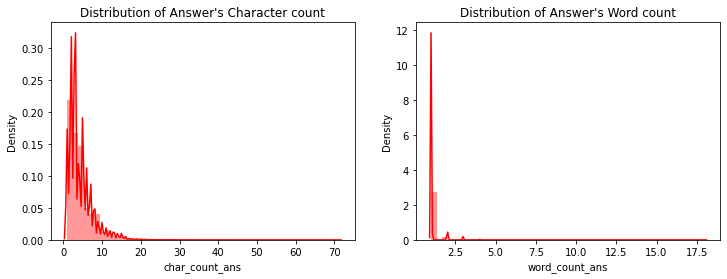

In [19]:
# Plot Distribution of Character count, Word count of answers
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(char_count_ans, color='red')
plt.title('Distribution of Answer\'s Character count')
plt.xlabel('char_count_ans')
plt.subplot(1,2,2)
sns.distplot(word_count_ans, color='red')
plt.title('Distribution of Answer\'s Word count')
plt.xlabel('word_count_ans')
plt.show()

In [20]:
# Percentile of word_count_ans
for i in range(0,101,10):
    print(f"{i}th percentile {np.percentile(word_count_ans,i)}")
print("-"*25)
for i in range(91,101,1):
    print(f"{i}th percentile {np.percentile(word_count_ans,i)}")

0th percentile 1.0
10th percentile 1.0
20th percentile 1.0
30th percentile 1.0
40th percentile 1.0
50th percentile 1.0
60th percentile 1.0
70th percentile 1.0
80th percentile 1.0
90th percentile 1.0
100th percentile 18.0
-------------------------
91th percentile 1.0
92th percentile 1.0
93th percentile 2.0
94th percentile 2.0
95th percentile 2.0
96th percentile 2.0
97th percentile 2.0
98th percentile 3.0
99th percentile 3.0
100th percentile 18.0


In [21]:
print("The maximum character length of Answer:", max(char_count_ans))
print("The minimum character length of Answer:", min(char_count_ans))
print('The average character length of Answer:',int(sum(char_count_ans)/len(char_count_ans)))
print('-'*50)
print("The maximum word length of Answer:", max(word_count_ans))
print("The minimum word length of Answer:", min(word_count_ans))
print('The average word length of Answer:',int(sum(word_count_ans)/len(word_count_ans)))
print('-'*50)
print('Total number of unique Answers:',len(unique_ans))
print('Types of Answers as per given answer_type:',len(set(answer_type)))

The maximum character length of Answer: 71
The minimum character length of Answer: 1
The average character length of Answer: 4
--------------------------------------------------
The maximum word length of Answer: 18
The minimum word length of Answer: 1
The average word length of Answer: 1
--------------------------------------------------
Total number of unique Answers: 22350
Types of Answers as per given answer_type: 3


**Observations:**
* 92% of answers have one word length, 97% of answers have two word length and 99% of answers have three word length.
* The minimum word length of the answer is 1 and the maximum word length of the answer is 18.
* The minimum character  length of the answer is 1 and the maximum character length of the answer is 71.
* There are 3 types of answers as per given answer_type feature.

In [22]:
# create dataframe of answer_type and its counts
answer_type_df = (mscoco_train2014.groupby(['answer_type']).count()['answers']).to_frame()
answer_type_df['answer%'] = round(answer_type_df['answers'] / len(answer_type) * 100,2)
answer_type_df = answer_type_df.sort_values(by='answers',ascending=False)
answer_type_df

,answers,answer%
answer_type,,
other,219269,49.41
yes/no,166882,37.61
number,57606,12.98


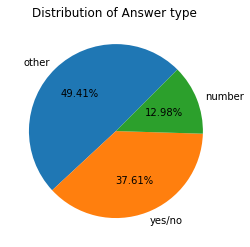

In [23]:
# plot pie chart of dataframe of answer_type and its counts
plt.pie(list(answer_type_df['answer%']), labels=list(answer_type_df.index), autopct='%1.2f%%', startangle=45)
plt.title('Distribution of Answer type ')
plt.show()

* 37.61% of answers have a "yes/no" answer_type which means these answers have only two categories "yes" or "no".
* 12.98% of answers have a "number" answer_type which means these answers are from the numeric/digit category.
* 49.41% of answers have "other" answer_type which means these answers contain simple text words.

In [24]:
# create dataframe of unique answers and its counts in decending order of answer_count
count = {}
for i in answer_preprocessed:
    count[i] = count.get(i, 0) + 1
    
answer_df = pd.DataFrame(list(count.items()),columns=["answer","answer_count"])
answer_df["answer%"] = answer_df["answer_count"]/len(answer_preprocessed)*100  
answer_df = answer_df.sort_values(by='answer_count',ascending=False)
answer_df.head(10)

,answer,answer_count,answer%
3,yes,84978,19.149670
11,no,82516,18.594862
15,1,12541,2.826096
20,2,12215,2.752633
4,white,8916,2.009208
38,3,6536,1.472878
16,blue,5455,1.229276
6,red,5201,1.172038
36,black,5066,1.141616
96,0,4977,1.121560


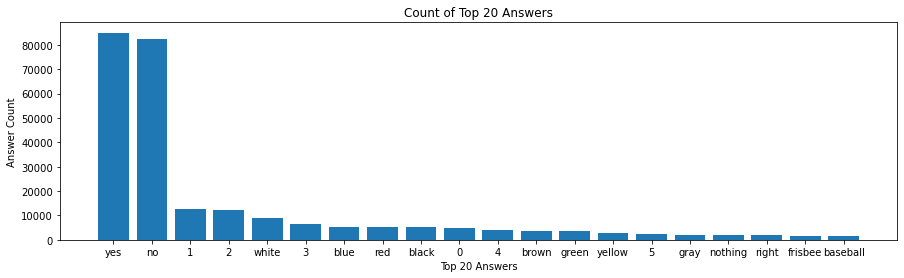

In [25]:
# Plot top 20 answers and its count from above dataframe
plt.figure(figsize=(15,4))
plt.bar(list(answer_df['answer'])[:20], list(answer_df['answer_count'])[:20])
plt.title('Count of Top 20 Answers')
plt.xlabel('Top 20 Answers')
plt.ylabel('Answer Count')
plt.xticks(list(answer_df['answer'])[:20])
plt.show()

**Observations:**
* A very large number of the answers are "yes" and "no".
* In number answer_type, 1,2,3,0,4,5 these numbers have more counts than other numbers.
* In other answer_type, color names have more counts which means most questions may be color related.

In [26]:
print(f"Top 1000 answers coverd {round(sum(list(answer_df['answer%'][:1000])),2)}% of datapoints")
print(f"Top 2000 answers coverd {round(sum(list(answer_df['answer%'][:2000])),2)}% of datapoints")
print(f"Top 3000 answers coverd {round(sum(list(answer_df['answer%'][:3000])),2)}% of datapoints")

Top 1000 answers coverd 87.5% of datapoints
Top 2000 answers coverd 91.26% of datapoints
Top 3000 answers coverd 93.11% of datapoints


* We will consider the top 1000 or 2000 answers as class labels, and see this problem as a multi-class classification problem.

**Questions & Answers who have answer length >= 10**

In [27]:
# Questions & Answers who have answer length >= 10
for i,a in enumerate(answer_preprocessed):
    if len(a.split()) >= 10:
        print('Que:',question_preprocessed[i])
        print('Ans:',a)
        print('Length of Ans:',len(a.split()))
        print("-"*50)

Que: what we can read from the picture
Ans: meter remains as courtesy to cyclists please pay at pay box
Length of Ans: 11
--------------------------------------------------
Que: what does the box say
Ans: i want to have my cake and eat it and i want you to think i lost weight
Length of Ans: 18
--------------------------------------------------
Que: what do the signs say
Ans: stadium cage no spikes in batting cage turf shoes only
Length of Ans: 10
--------------------------------------------------
Que: which numbers can you make out
Ans: 1 2 3 4 5 6 7 8 9 0
Length of Ans: 10
--------------------------------------------------
Que: what does the first sign say
Ans: please make sure that bag you claim is yours as many bags look alike
Length of Ans: 14
--------------------------------------------------
Que: what does the sign say
Ans: if you hit this sign you will hit that bridge
Length of Ans: 10
--------------------------------------------------
Que: what are these people doing
Ans: one m

**Observations:**
* The answers who have a length of 10 or more than 10 words are mostly answers of 'what' and 'why' questions.
* These 'what' and 'why' questions are about caption reading or sign reading from an image or giving description or reasons from an image.

## 1.4 EDA - Question & Answers

In [28]:
# Create dataframe of first two words of question and its most common answers
question_df = pd.DataFrame(question_preprocessed,columns=["question"])
question_split_df = question_df['question'].str.split(" ", expand = True)
question_answer_df = question_split_df.iloc[:,:-20]
question_answer_df['answer'] = answer

def que_ans_analysis2(word_1,word_2):
    word_1_2_df = question_answer_df[(question_answer_df[0] == word_1) & (question_answer_df[1] == word_2)]
    word_1_2_count = (word_1_2_df.groupby(['answer']).count()[0]).to_frame()
    word_1_2_count = word_1_2_count.sort_values(by=0,ascending=False)
    
    plt.figure(figsize=(20,4))
    plt.bar(list(word_1_2_count.index)[:20], list(word_1_2_count[0])[:20])
    plt.title('Count of Top 20 Answers of "'+word_1+' '+word_2+'" questions')
    plt.xlabel('Top 20 Answers of "'+word_1+' '+word_2+'" questions')
    plt.ylabel('Count')
    plt.xticks(list(word_1_2_count.index)[:20])
    plt.show()

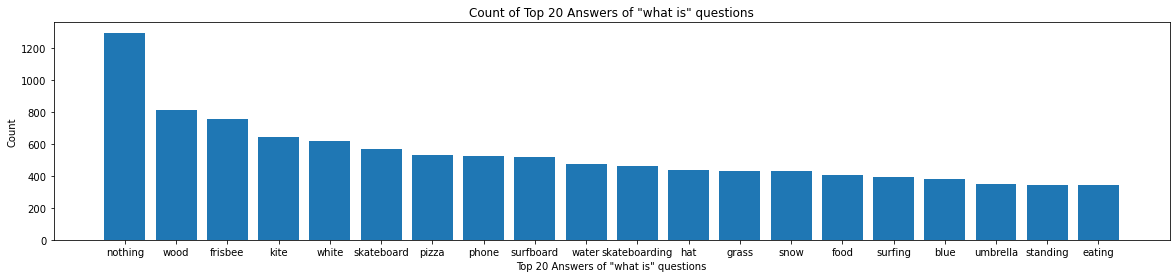

In [29]:
que_ans_analysis2("what","is")

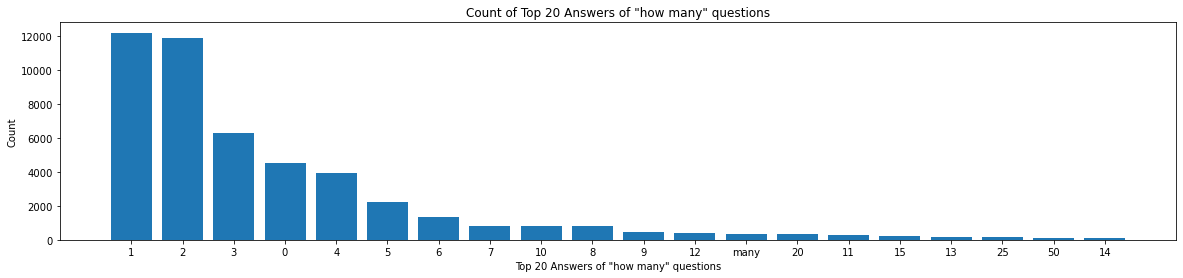

In [30]:
que_ans_analysis2("how","many")

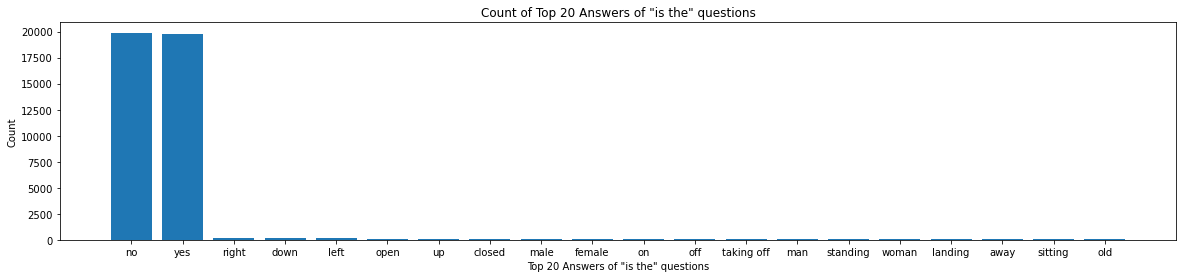

In [31]:
que_ans_analysis2("is","the")

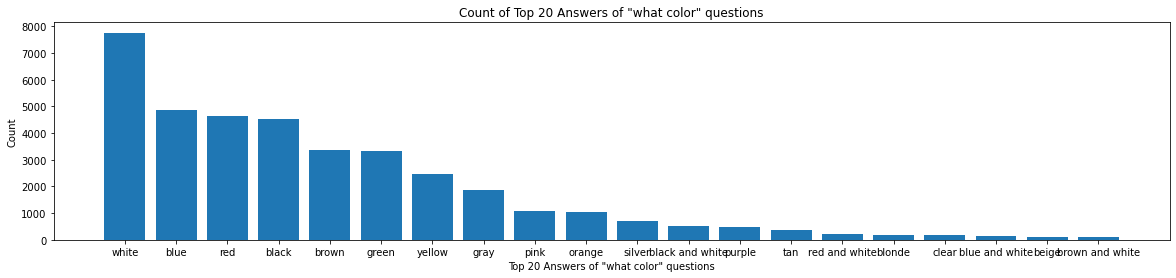

In [32]:
que_ans_analysis2("what","color")

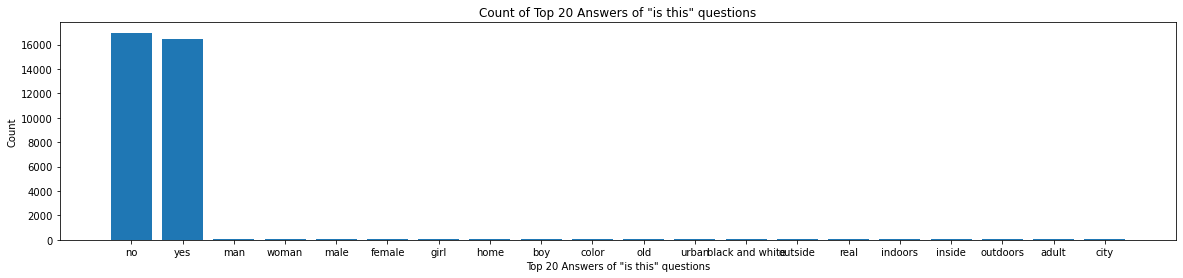

In [33]:
que_ans_analysis2("is","this")

**Observations:**
* The questions that start with "What" have the most answers color names, sports names, activity names, object names, or food names.
* The questions that start with "how" have the most answers numbers or quantifier words like many, few, more, some, all, etc.
* The questions that start with "is", have a very large number of answers only "yes" or "no".

# 2. Binary Abstract Train Dataset

In [2]:
# Convert .josn file to .csv
b_abstract_train2017_que = json.load(open(f'0Data/Binary Abstract/Que/OpenEnded_abstract_v002_train2017_questions.json','r'))
b_abstract_train2017_ans = json.load(open(f'0Data/Binary Abstract/Ans/abstract_v002_train2017_annotations.json','r'))

b_abstract_train2017_que_df = pd.DataFrame(b_abstract_train2017_que['questions'])
b_abstract_train2017_ans_df = pd.DataFrame(b_abstract_train2017_ans['annotations'])

b_abstract_train2017 = pd.merge(b_abstract_train2017_que_df, b_abstract_train2017_ans_df, on=["image_id", "question_id"])

cols = ['image_id','question_id','question','question_type','multiple_choice_answer','answers','answer_type']
b_abstract_train2017 = b_abstract_train2017[cols]

#convert image_id to image_path
image_path = []
for i in (range(len(b_abstract_train2017))):
    imdir='scene_img_abstract_v002_train2017/abstract_v002_train2015_%012d.png'
    image_path.append(imdir%(b_abstract_train2017['image_id'][i]))
b_abstract_train2017['image_id'] = image_path

# create a list of multiple answers of an question
answers_list = []
for i in (range(len(b_abstract_train2017))):
    ans_list = []
    for dic in (b_abstract_train2017['answers'][i]):
        ans_list.append(dic['answer'])
    answers_list.append(ans_list)
b_abstract_train2017['answers'] = answers_list

# save dataframe to .csv
# b_abstract_train2017.to_csv("0Data/b_abstract_train2017.csv",index=False)

# b_abstract_train2017 = pd.read_csv("0Data/b_abstract_train2017.csv")
print('Number of Question & Answer in Binary Abstract Train Dataset:',len(b_abstract_train2017))
b_abstract_train2017.head(2)

Number of Question & Answer in Binary Abstract Train Dataset: 22055


,image_id,question_id,question,question_type,multiple_choice_answer,answers,answer_type
0,scene_img_abstract_v002_train2017/abstract_v00...,870,Is the boy having wine?,is the boy,yes,"[no, yes, yes, yes, yes, yes, yes, yes, yes, yes]",yes/no
1,scene_img_abstract_v002_train2017/abstract_v00...,900000870,Is the boy having wine?,is the boy,no,"[no, no, no, no, no, no, no, no, no, no]",yes/no


In [3]:
binary_abstract_path = "0Data/Binary Abstract/Image/"

image_path = list(b_abstract_train2017['image_id'])
question = list(b_abstract_train2017['question'])
answer = list(b_abstract_train2017['multiple_choice_answer'])

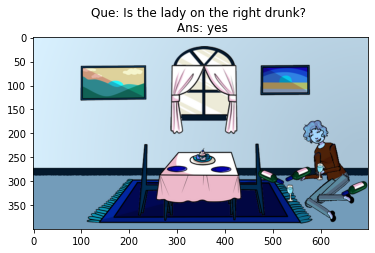

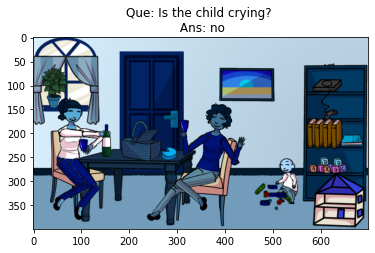

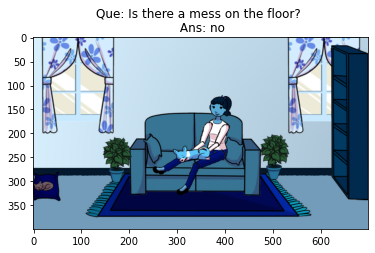

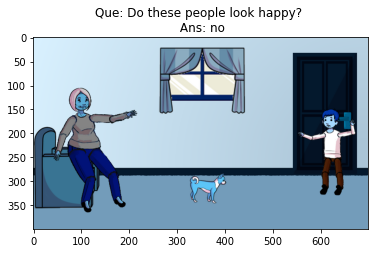

In [4]:
# Plot sample images, questions and answers
temp = random.sample(range(0, 1000), 4)
for a,i in enumerate(temp):
    image = cv2.imread(binary_abstract_path+image_path[i])
    plt.figure()
    plt.title(f'Que: {question[i]} \n Ans: {answer[i]}')
    plt.imshow(image)

**Observations:**
* We can see that the shapes of all the images are same, but we need to analyze the shape of the images.
* Most of the questions are simple and have clean text but some questions contain common word contractions like what's, it's, they're, etc, and noun contractions like guy's, man's, dog's, etc., and few words contain quotes, eg: "Merry", etc.
* All the answers are simple one word 'yes' or 'no' answers.

In [4]:
# Find the punctuations present in question and answer dataset
def find_punctuation(text):
    punctuation_list = []
    for t in text:
        for i in t:
            if i in string.punctuation:  
                punctuation_list.append(i)
    punctuation_list = list(set(punctuation_list))
    return punctuation_list

que_punct_list = find_punctuation(question)
ans_punct_list = find_punctuation(answer)
print(f'{len(que_punct_list)} punctuations found in the Question Dataset:\n{que_punct_list}')
print('-'*50)
print(f'{len(ans_punct_list)} punctuations found in the Answer Dataset:\n{ans_punct_list}')

7 punctuations found in the Question Dataset:
[':', '-', '.', "'", ',', '?', '"']
--------------------------------------------------
0 punctuations found in the Answer Dataset:
[]


**Observations:**
* Above is a list of 7 punctuations found in the question dataset and no punctuations found in the answer dataset.
* Hence, we need to perform data cleaning operation on question dataset and text lower operation on answer dataset before EDA.

In [7]:
# Question and Answer text preprocessing
b_abstract_train2017["question_preprocessed"] = b_abstract_train2017["question"].map(lambda x: text_preprocess(x))
b_abstract_train2017["answer_preprocessed"] = b_abstract_train2017["multiple_choice_answer"].map(lambda x: text_preprocess_ans(x))

In [9]:
# Sample Questions and Answers Befor and after text preprocessing
temp = random.sample(range(0, len(b_abstract_train2017)), 4)
for i in temp:
    print(f'Que: {b_abstract_train2017["question"][i]}\nAns: {b_abstract_train2017["multiple_choice_answer"][i]}')
print('-'*50)
for i in temp:
    print(f'Que: {b_abstract_train2017["question_preprocessed"][i]}\nAns: {b_abstract_train2017["answer_preprocessed"][i]}')

Que: Is the girl having fun?
Ans: yes
Que: Is this woman a teenager?
Ans: yes
Que: Did the monkey bars grow here?
Ans: no
Que: Is she moving the picture?
Ans: no
--------------------------------------------------
Que: is the girl having fun
Ans: yes
Que: is this woman a teenager
Ans: yes
Que: did the monkey bars grow here
Ans: no
Que: is she moving the picture
Ans: no


* We can see that all the punctuation present in questions and answers are removed and the word contractions are also replaced with their expanded form. 

In [8]:
b_abstract_train2017 = b_abstract_train2017.drop(['question', 'multiple_choice_answer'], axis=1)

cols = ['image_id','question_id','question_preprocessed','question_type','answer_preprocessed','answers','answer_type']
b_abstract_train2017 = b_abstract_train2017[cols]

# save dataframe to .csv
# b_abstract_train2017.to_csv("0Data/b_abstract_train2017_preprocessed.csv",index=False)

# b_abstract_train2017 = pd.read_csv("0Data/b_abstract_train2017_preprocessed.csv")
print('Number of Question & Answer in Binary Abstract Train Dataset:',len(b_abstract_train2017))
b_abstract_train2017.head(2)

Number of Question & Answer in Binary Abstract Train Dataset: 22055


,image_id,question_id,question_preprocessed,question_type,answer_preprocessed,answers,answer_type
0,scene_img_abstract_v002_train2017/abstract_v00...,870,is the boy having wine,is the boy,yes,"[no, yes, yes, yes, yes, yes, yes, yes, yes, yes]",yes/no
1,scene_img_abstract_v002_train2017/abstract_v00...,900000870,is the boy having wine,is the boy,no,"[no, no, no, no, no, no, no, no, no, no]",yes/no


In [9]:
image_path = list(b_abstract_train2017['image_id'])
question_preprocessed = list(b_abstract_train2017['question_preprocessed'])
answer_preprocessed = list(b_abstract_train2017['answer_preprocessed'])
question_type = list(b_abstract_train2017['question_type'])
answer_type = list(b_abstract_train2017['answer_type'])

## 2.1 EDA - Image

In [10]:
# Calculate image shape
image_shape = []
for i in tqdm(range(len(b_abstract_train2017))):
    image = cv2.imread(binary_abstract_path+image_path[i])
    image_shape.append(image.shape)

100%|███████████████████████████████████████████████████████████████████████████| 22055/22055 [01:52<00:00, 196.59it/s]


In [11]:
height = list((list(zip(*image_shape)))[0])
width = list((list(zip(*image_shape)))[1])
channel = list((list(zip(*image_shape)))[2])

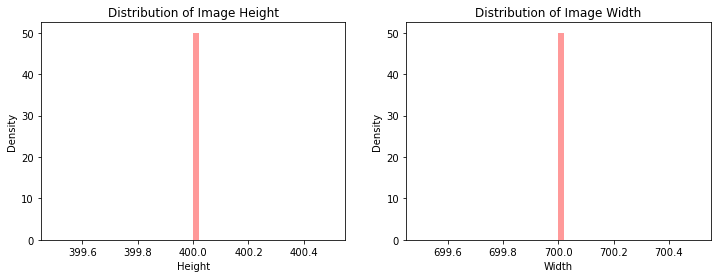

In [12]:
# Plot Distribution Image Height and Width
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(height, color='red')
plt.title('Distribution of Image Height')
plt.xlabel('Height')
plt.subplot(1,2,2)
sns.distplot(width, color='red')
plt.title('Distribution of Image Width')
plt.xlabel('Width')
plt.show()

In [13]:
print(f"Height:{list(set(height))[0]}, Width:{list(set(width))[0]}")
print(f"All the Images have same channel depth of {list(set(channel))[0]}.")

Height:400, Width:700
All the Images have same channel depth of 3.


**Observations:**
* All the images have similar height and width, but we need to reshape them in a smaller size to speed up the training process.
* All the images have the same channel depth of 3 means they all are color(RGB) images. 

## 2.2 EDA - Question

In [14]:
# Create list of Character count, Word count, First one word, First two words, and unique words of questions 
char_count_que = []
word_count_que = []
first_word_que = []
two_word_que = []
unique_word_que = []

for q in question_preprocessed:
    char_count_que.append(len(q))
    word_count_que.append(len(q.split()))
    first_word_que.append(q.split()[0].lower())
    two_word_que.append(" ".join(q.split()[:2]).lower())
    unique_word_que.extend(q.split())
unique_word_que = set(unique_word_que)

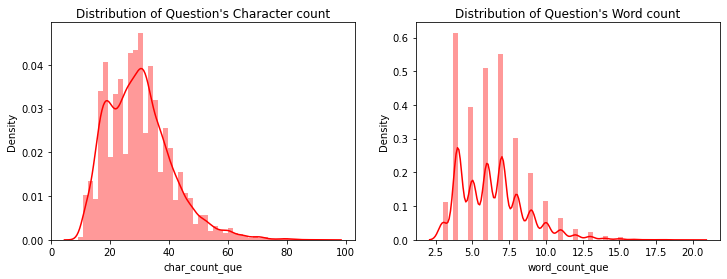

In [15]:
# Plot Distribution of Character count, Word count of question
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(char_count_que, color='red')
plt.title('Distribution of Question\'s Character count')
plt.xlabel('char_count_que')
plt.subplot(1,2,2)
sns.distplot(word_count_que, color='red')
plt.title('Distribution of Question\'s Word count')
plt.xlabel('word_count_que')
plt.show()

In [16]:
# Percentile of word_count_que
for i in range(0,101,10):
    print(f"{i}th percentile {np.percentile(word_count_que,i)}")
print("-"*25)
for i in range(91,101,1):
    print(f"{i}th percentile {np.percentile(word_count_que,i)}")

0th percentile 3.0
10th percentile 4.0
20th percentile 4.0
30th percentile 5.0
40th percentile 6.0
50th percentile 6.0
60th percentile 7.0
70th percentile 7.0
80th percentile 8.0
90th percentile 9.0
100th percentile 20.0
-------------------------
91th percentile 9.0
92th percentile 10.0
93th percentile 10.0
94th percentile 10.0
95th percentile 11.0
96th percentile 11.0
97th percentile 11.0
98th percentile 12.0
99th percentile 13.0
100th percentile 20.0


In [17]:
print("The maximum character length of Question:", max(char_count_que))
print("The minimum character length of Question:", min(char_count_que))
print('The average character length of Question:',int(sum(char_count_que)/len(char_count_que)))
print('-'*50)
print("The maximum word length of Question:", max(word_count_que))
print("The minimum word length of Question:", min(word_count_que))
print('The average word length of Question:',int(sum(word_count_que)/len(word_count_que)))
print('-'*50)
print('Total unique words in questions:',len(unique_word_que))

The maximum character length of Question: 94
The minimum character length of Question: 9
The average character length of Question: 29
--------------------------------------------------
The maximum word length of Question: 20
The minimum word length of Question: 3
The average word length of Question: 6
--------------------------------------------------
Total unique words in questions: 2747


**Observations:**
* Most of the questions have character length between 15 to 45 characters.
* Few questions have more than 60 character length.
* Most of the questions have word length between 4 to 9 words.
* Maximum word length of question is 20 words and the minimum word length of question is 3 words.
* Most of the questions have less than 10 words but few questions also have greater than 10 words.

In [18]:
print('Types of questions as per given question_type:',len(set(question_type)))
print('Types of questions as per first one word of question:',len(set(first_word_que)))
print('Types of questions as per first two word of question:',len(set(two_word_que)))

Types of questions as per given question_type: 42
Types of questions as per first one word of question: 32
Types of questions as per first two word of question: 268


In [19]:
# Create dataframe of First one word of question and its question count
count = {}
for i in first_word_que:
    count[i] = count.get(i, 0) + 1

first_word_que_df = pd.DataFrame(list(count.items()),columns=["first_word","question_count"])
first_word_que_df["question_%"] = first_word_que_df["question_count"]/len(first_word_que)*100  
first_word_que_df = first_word_que_df.sort_values(by='question_count',ascending=False)
first_word_que_df.head(5)

,first_word,question_count,question_%
0,is,14102,63.940150
1,are,3889,17.633190
4,does,1618,7.336205
5,do,694,3.146679
3,will,543,2.462027


* Most of the questions start with "is", "are", and "does" words. Let's check what is second most words after "is", "are", and "does".

In [20]:
# Create dataframe of First two words of question and its question count
count = {}
for i in two_word_que:
    count[i] = count.get(i, 0) + 1

two_word_que_df = pd.DataFrame(list(count.items()),columns=["two_word","question_count"])
two_word_que_df["question_%"] = two_word_que_df["question_count"]/len(first_word_que)*100  
two_word_que_df = two_word_que_df.sort_values(by='question_count',ascending=False)
two_word_que_df.head(10)

,two_word,question_count,question_%
0,is the,9553,43.314441
2,is there,1942,8.805260
6,are the,1689,7.658127
11,does the,1253,5.681251
5,are there,836,3.790524
19,are they,735,3.332578
1,is it,704,3.192020
8,is this,604,2.738608
7,will the,425,1.927001
40,is she,359,1.627749


**Observations:**
* After "is" the next most common words are "the", "there", "it", and "this".
* After "are" the next most common words are "the", "there", and "they".
* After "does" the next most common word is "the".

## 2.3 EDA - Answer

In [21]:
# Create list of Character count, Word count, and unique words of answers 
char_count_ans = []
word_count_ans = []
for a in (answer_preprocessed):
    char_count_ans.append(len(a))
    word_count_ans.append(len(a.split()))
    
unique_ans = set(answer_preprocessed)

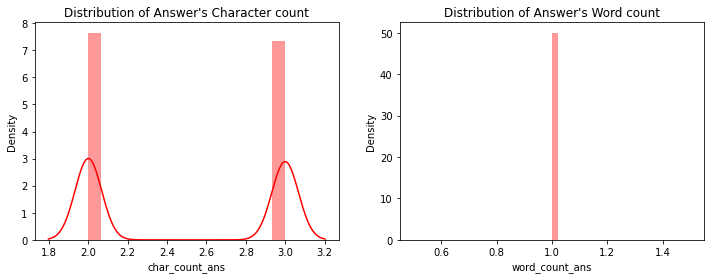

In [22]:
# Plot Distribution of Character count, Word count of answers
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(char_count_ans, color='red')
plt.title('Distribution of Answer\'s Character count')
plt.xlabel('char_count_ans')
plt.subplot(1,2,2)
sns.distplot(word_count_ans, color='red')
plt.title('Distribution of Answer\'s Word count')
plt.xlabel('word_count_ans')
plt.show()

In [23]:
print("The maximum character length of Answer:", max(char_count_ans))
print("The minimum character length of Answer:", min(char_count_ans))
print('The average character length of Answer:',int(sum(char_count_ans)/len(char_count_ans)))
print('-'*50)
print("The maximum word length of Answer:", max(word_count_ans))
print("The minimum word length of Answer:", min(word_count_ans))
print('The average word length of Answer:',int(sum(word_count_ans)/len(word_count_ans)))
print('-'*50)
print('Total number of unique Answers:',len(unique_ans))
print('Types of Answers as per given answer_type:',len(set(answer_type)))

The maximum character length of Answer: 3
The minimum character length of Answer: 2
The average character length of Answer: 2
--------------------------------------------------
The maximum word length of Answer: 1
The minimum word length of Answer: 1
The average word length of Answer: 1
--------------------------------------------------
Total number of unique Answers: 2
Types of Answers as per given answer_type: 1


**Observations:**
* All the answers have only one word.
* The minimum character length of the answer is 2 and the maximum character length of the answer is 3.
* There is only one types of answer as per given answer_type feature.

In [24]:
# create dataframe of answer_type and its counts
answer_type_df = (b_abstract_train2017.groupby(['answer_type']).count()['answers']).to_frame()
answer_type_df['answer%'] = round(answer_type_df['answers'] / len(answer_type) * 100,2)
answer_type_df = answer_type_df.sort_values(by='answers',ascending=False)
answer_type_df

,answers,answer%
answer_type,,
yes/no,22055,100.0


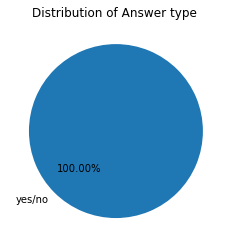

In [25]:
# plot pie chart of dataframe of answer_type and its counts
plt.pie(list(answer_type_df['answer%']), labels=list(answer_type_df.index), autopct='%1.2f%%', startangle=45)
plt.title('Distribution of Answer type ')
plt.show()

* 100% of answers have a "yes/no" answer_type which means all the answers have only two categories "yes" or "no".

In [26]:
# create dataframe of unique answers and its counts in decending order of answer_count
count = {}
for i in answer_preprocessed:
    count[i] = count.get(i, 0) + 1
    
answer_df = pd.DataFrame(list(count.items()),columns=["answer","answer_count"])
answer_df["answer%"] = answer_df["answer_count"]/len(answer_preprocessed)*100  
answer_df = answer_df.sort_values(by='answer_count',ascending=False)
answer_df.head(10)

,answer,answer_count,answer%
1,no,11240,50.9635
0,yes,10815,49.0365


In [27]:
print(f"Top 2 answers coverd {round(sum(list(answer_df['answer%'][:2])),2)}% of datapoints")

Top 2 answers coverd 100.0% of datapoints


**Observations:**
* All the answers are "yes" or "no".
* We will consider these two answers as class labels, and see this problem as a binary-class classification problem.
* This Binary Abstract Train dataset is balanced dataset.

# 3. Abstract Train Dataset

In [31]:
# Convert .josn file to .csv
abstract_train2015_que = json.load(open(f'0Data/Abstract/Que/MultipleChoice_abstract_v002_train2015_questions.json','r'))
abstract_train2015_ans = json.load(open(f'0Data/Abstract/Ans/abstract_v002_train2015_annotations.json','r'))

abstract_train2015_que_df = pd.DataFrame(abstract_train2015_que['questions'])
abstract_train2015_ans_df = pd.DataFrame(abstract_train2015_ans['annotations'])

abstract_train2015 = pd.merge(abstract_train2015_que_df, abstract_train2015_ans_df, on=["image_id", "question_id"])

cols = ['image_id','question_id','question','question_type','multiple_choices','multiple_choice_answer','answers','answer_type']
abstract_train2015 = abstract_train2015[cols]

#convert image_id to image_path
image_path = []
for i in (range(len(abstract_train2015))):
    imdir='scene_img_abstract_v002_train2015/abstract_v002_train2015_%012d.png'
    image_path.append(imdir%(abstract_train2015['image_id'][i]))
abstract_train2015['image_id'] = image_path

# create a list of multiple answers of an question
answers_list = []
for i in (range(len(abstract_train2015))):
    ans_list = []
    for dic in (abstract_train2015['answers'][i]):
        ans_list.append(dic['answer'])
    answers_list.append(ans_list)
abstract_train2015['answers'] = answers_list

# save dataframe to .csv
# abstract_train2015.to_csv("0Data/abstract_train2015.csv",index=False)

# abstract_train2015 = pd.read_csv("0Data/abstract_train2015.csv")
print('Number of Question & Answer in Abstract Train Dataset:',len(abstract_train2015))
abstract_train2015.head(2)

Number of Question & Answer in Abstract Train Dataset: 60000


,image_id,question_id,question,question_type,multiple_choices,multiple_choice_answer,answers,answer_type
0,scene_img_abstract_v002_train2015/abstract_v00...,117792,Who looks happier?,who,"['alive', '1', 'woman', 'purple', '2', 'yes', ...",man,"['old person', 'man', 'man', 'man', 'old man',...",other
1,scene_img_abstract_v002_train2015/abstract_v00...,117790,Where is the woman sitting?,where is the,"['3', 'no', 'blue', 'red', '1', 'slide, monkey...",blanket,"['on blanket', 'blanket', 'on blanket', 'blank...",other


In [32]:
abstract_path = "0Data/Abstract/Image/"

image_path = list(abstract_train2015['image_id'])
question = list(abstract_train2015['question'])
answer = list(abstract_train2015['multiple_choice_answer'])

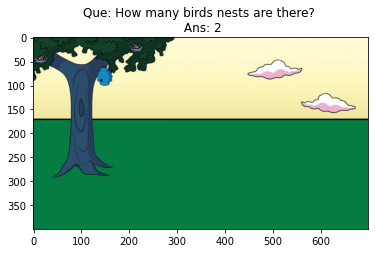

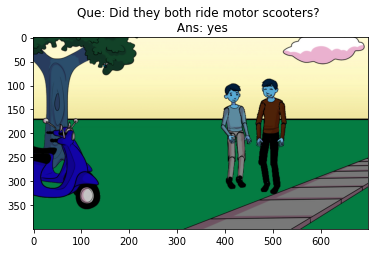

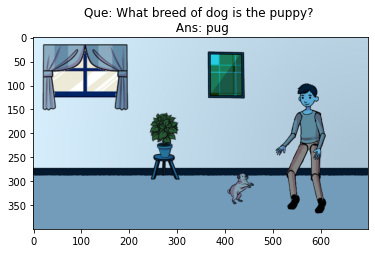

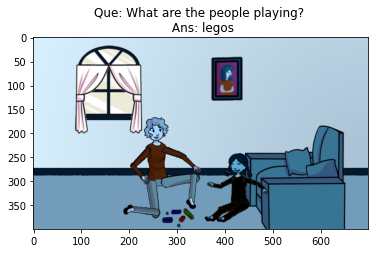

In [33]:
# Plot sample images, questions and answers
temp = random.sample(range(0, 1000), 4)
for a,i in enumerate(temp):
    image = cv2.imread(abstract_path+image_path[i])
    plt.figure()
    plt.title(f'Que: {question[i]} \n Ans: {answer[i]}')
    plt.imshow(image)

**Observations:**
* We can see that the shapes of all the images are same, but we need to analyze the shape of the images.
* Most of the questions are simple and have clean text but some questions contain common word contractions like what's, it's, they're, etc, and noun contractions like guy's, man's, dog's, etc., and few words contain quotes, eg: "Merry", etc.
* Most of the answers are simple one word or numeric and clean text but some answers contain punctuations.

In [35]:
# Find the punctuations present in question and answer dataset
def find_punctuation(text):
    punctuation_list = []
    for t in text:
        for i in t:
            if i in string.punctuation:  
                punctuation_list.append(i)
    punctuation_list = list(set(punctuation_list))
    return punctuation_list

que_punct_list = find_punctuation(question)
ans_punct_list = find_punctuation(answer)
print(f'{len(que_punct_list)} punctuations found in the Question Dataset:\n{que_punct_list}')
print('-'*50)
print(f'{len(ans_punct_list)} punctuations found in the Answer Dataset:\n{ans_punct_list}')

11 punctuations found in the Question Dataset:
['(', '.', ';', ':', '-', ',', "'", '/', ')', '"', '?']
--------------------------------------------------
8 punctuations found in the Answer Dataset:
['.', ':', '-', ',', "'", '%', '"', '?']


**Observations:**
* Above is a list of 11 punctuations found in the question dataset and 8 punctuations found in the answer dataset.
* Hence, we need to perform data cleaning operation on question and answer dataset before EDA.

In [36]:
# Question and Answer text preprocessing
abstract_train2015["question_preprocessed"] = abstract_train2015["question"].map(lambda x: text_preprocess(x))
abstract_train2015["answer_preprocessed"] = abstract_train2015["multiple_choice_answer"].map(lambda x: text_preprocess_ans(x))

In [37]:
# Sample Questions and Answers Befor and after text preprocessing
temp = random.sample(range(0, len(abstract_train2015)), 4)
for i in temp:
    print(f'Que: {abstract_train2015["question"][i]}\nAns: {abstract_train2015["multiple_choice_answer"][i]}')
print('-'*50)
for i in temp:
    print(f'Que: {abstract_train2015["question_preprocessed"][i]}\nAns: {abstract_train2015["answer_preprocessed"][i]}')

Que: What is the man touching on the bookshelf?
Ans: nothing
Que: What are the children playing with?
Ans: dog
Que: Will it get cloudy soon?
Ans: yes
Que: Is the old man trying to eat butterflies?
Ans: no
--------------------------------------------------
Que: what is the man touching on the bookshelf
Ans: nothing
Que: what are the children playing with
Ans: dog
Que: will it get cloudy soon
Ans: yes
Que: is the old man trying to eat butterflies
Ans: no


* We can see that all the punctuation present in questions and answers are removed and the word contractions are also replaced with their expanded form.

In [38]:
abstract_train2015 = abstract_train2015.drop(['question', 'multiple_choice_answer'], axis=1)

cols = ['image_id','question_id','question_preprocessed','question_type','answer_preprocessed','answers','answer_type']
abstract_train2015 = abstract_train2015[cols]

# save dataframe to .csv
# abstract_train2015.to_csv("0Data/abstract_train2015_preprocessed.csv",index=False)

# abstract_train2015 = pd.read_csv("0Data/abstract_train2015_preprocessed.csv")
print('Number of Question & Answer in Abstract Train Dataset:',len(abstract_train2015))
abstract_train2015.head(2)

Number of Question & Answer in Abstract Train Dataset: 60000


,image_id,question_id,question_preprocessed,question_type,answer_preprocessed,answers,answer_type
0,scene_img_abstract_v002_train2015/abstract_v00...,117792,who looks happier,who,man,"['old person', 'man', 'man', 'man', 'old man',...",other
1,scene_img_abstract_v002_train2015/abstract_v00...,117790,where is the woman sitting,where is the,blanket,"['on blanket', 'blanket', 'on blanket', 'blank...",other


In [39]:
image_path = list(abstract_train2015['image_id'])
question_preprocessed = list(abstract_train2015['question_preprocessed'])
answer_preprocessed = list(abstract_train2015['answer_preprocessed'])
question_type = list(abstract_train2015['question_type'])
answer_type = list(abstract_train2015['answer_type'])

## 3.1 EDA - Image

In [40]:
# Calculate image shape
image_shape = []
for i in tqdm(range(len(abstract_train2015))):
    image = cv2.imread(abstract_path+image_path[i])
    image_shape.append(image.shape)

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [05:24<00:00, 185.04it/s]


In [41]:
height = list((list(zip(*image_shape)))[0])
width = list((list(zip(*image_shape)))[1])
channel = list((list(zip(*image_shape)))[2])

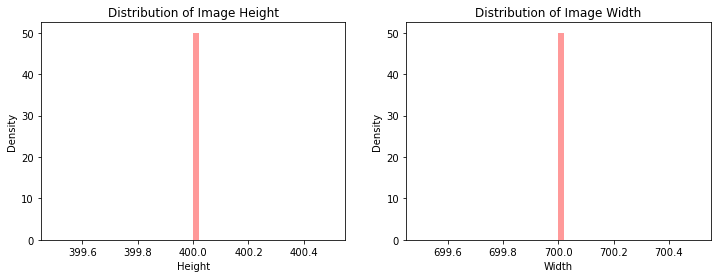

In [42]:
# Plot Distribution Image Height and Width
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(height, color='red')
plt.title('Distribution of Image Height')
plt.xlabel('Height')
plt.subplot(1,2,2)
sns.distplot(width, color='red')
plt.title('Distribution of Image Width')
plt.xlabel('Width')
plt.show()

In [43]:
print(f"Height:{list(set(height))[0]}, Width:{list(set(width))[0]}")
print(f"All the Images have same channel depth of {list(set(channel))[0]}.")

Height:400, Width:700
All the Images have same channel depth of 3.


**Observations:**
* All the images have similar height and width, but we need to reshape them in a smaller size to speed up the training process.
* All the images have the same channel depth of 3 means they all are color(RGB) images. 

## 3.2 EDA - Question

In [44]:
# Create list of Character count, Word count, First one word, First two words, and unique words of questions 
char_count_que = []
word_count_que = []
first_word_que = []
two_word_que = []
unique_word_que = []

for q in question_preprocessed:
    char_count_que.append(len(q))
    word_count_que.append(len(q.split()))
    first_word_que.append(q.split()[0].lower())
    two_word_que.append(" ".join(q.split()[:2]).lower())
    unique_word_que.extend(q.split())
unique_word_que = set(unique_word_que)

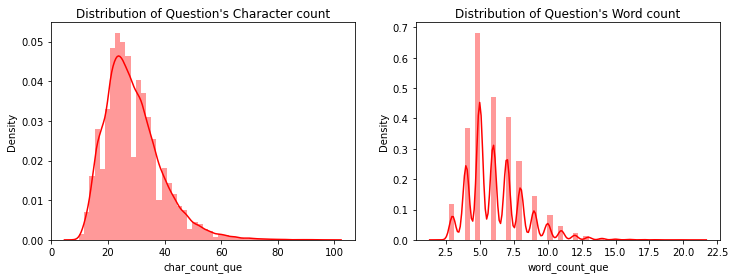

In [45]:
# Plot Distribution of Character count, Word count of question
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(char_count_que, color='red')
plt.title('Distribution of Question\'s Character count')
plt.xlabel('char_count_que')
plt.subplot(1,2,2)
sns.distplot(word_count_que, color='red')
plt.title('Distribution of Question\'s Word count')
plt.xlabel('word_count_que')
plt.show()

In [46]:
# Percentile of word_count_que
for i in range(0,101,10):
    print(f"{i}th percentile {np.percentile(word_count_que,i)}")
print("-"*25)
for i in range(91,101,1):
    print(f"{i}th percentile {np.percentile(word_count_que,i)}")

0th percentile 2.0
10th percentile 4.0
20th percentile 5.0
30th percentile 5.0
40th percentile 5.0
50th percentile 6.0
60th percentile 6.0
70th percentile 7.0
80th percentile 8.0
90th percentile 9.0
100th percentile 21.0
-------------------------
91th percentile 9.0
92th percentile 9.0
93th percentile 9.0
94th percentile 10.0
95th percentile 10.0
96th percentile 10.0
97th percentile 11.0
98th percentile 11.0
99th percentile 13.0
100th percentile 21.0


In [47]:
print("The maximum character length of Question:", max(char_count_que))
print("The minimum character length of Question:", min(char_count_que))
print('The average character length of Question:',int(sum(char_count_que)/len(char_count_que)))
print('-'*50)
print("The maximum word length of Question:", max(word_count_que))
print("The minimum word length of Question:", min(word_count_que))
print('The average word length of Question:',int(sum(word_count_que)/len(word_count_que)))
print('-'*50)
print('Total unique words in questions:',len(unique_word_que))

The maximum character length of Question: 99
The minimum character length of Question: 8
The average character length of Question: 28
--------------------------------------------------
The maximum word length of Question: 21
The minimum word length of Question: 2
The average word length of Question: 6
--------------------------------------------------
Total unique words in questions: 4511


**Observations:**
* Most of the questions have character length between 20 to 40 characters.
* Few questions have more than 60 character length.
* Most of the questions have word length between 4 to 8 words.
* Maximum word length of question is 21 words and the minimum word length of question is 2 words.
* Most of the questions have less than 10 words but few questions also have greater than 10 words.

In [48]:
print('Types of questions as per given question_type:',len(set(question_type)))
print('Types of questions as per first one word of question:',len(set(first_word_que)))
print('Types of questions as per first two word of question:',len(set(two_word_que)))

Types of questions as per given question_type: 81
Types of questions as per first one word of question: 80
Types of questions as per first two word of question: 1068


In [49]:
# Create dataframe of First one word of question and its question count
count = {}
for i in first_word_que:
    count[i] = count.get(i, 0) + 1

first_word_que_df = pd.DataFrame(list(count.items()),columns=["first_word","question_count"])
first_word_que_df["question_%"] = first_word_que_df["question_count"]/len(first_word_que)*100  
first_word_que_df = first_word_que_df.sort_values(by='question_count',ascending=False)
first_word_que_df.head(5)

,first_word,question_count,question_%
3,what,19909,33.181667
2,is,16276,27.126667
4,how,9026,15.043333
7,are,4480,7.466667
1,where,3139,5.231667


* Most of the questions start with "what", "is", and "how" words. Let's check what is second most words after "what", "is", and "how".

In [50]:
# Create dataframe of First two words of question and its question count
count = {}
for i in two_word_que:
    count[i] = count.get(i, 0) + 1

two_word_que_df = pd.DataFrame(list(count.items()),columns=["two_word","question_count"])
two_word_que_df["question_%"] = two_word_que_df["question_count"]/len(first_word_que)*100  
two_word_que_df = two_word_que_df.sort_values(by='question_count',ascending=False)
two_word_que_df.head(10)

,two_word,question_count,question_%
11,is the,11010,18.350000
8,what is,9761,16.268333
15,how many,8493,14.155000
4,what color,5356,8.926667
1,where is,2687,4.478333
16,is there,2113,3.521667
23,are the,1998,3.330000
21,does the,1406,2.343333
24,what are,992,1.653333
30,are there,934,1.556667


**Observations:**
* After "what" the next most common words are "is", "color", and "are".
* After "is" the next most common words are "the", and "there".
* After "how" the next most common word is "many".

## 3.3 EDA - Answer

In [51]:
# Create list of Character count, Word count, and unique words of answers 
char_count_ans = []
word_count_ans = []
for a in (answer_preprocessed):
    char_count_ans.append(len(a))
    word_count_ans.append(len(a.split()))
    
unique_ans = set(answer_preprocessed)

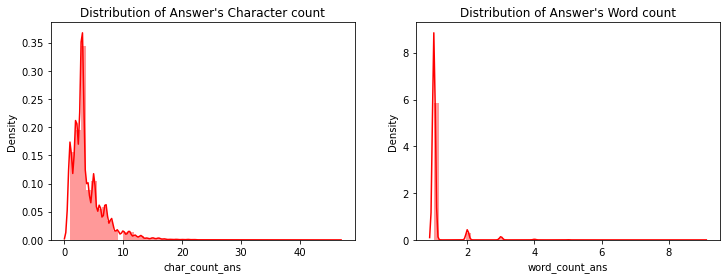

In [52]:
# Plot Distribution of Character count, Word count of answers
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(char_count_ans, color='red')
plt.title('Distribution of Answer\'s Character count')
plt.xlabel('char_count_ans')
plt.subplot(1,2,2)
sns.distplot(word_count_ans, color='red')
plt.title('Distribution of Answer\'s Word count')
plt.xlabel('word_count_ans')
plt.show()

In [53]:
# Percentile of word_count_ans
for i in range(0,101,10):
    print(f"{i}th percentile {np.percentile(word_count_ans,i)}")
print("-"*25)
for i in range(91,101,1):
    print(f"{i}th percentile {np.percentile(word_count_ans,i)}")

0th percentile 1.0
10th percentile 1.0
20th percentile 1.0
30th percentile 1.0
40th percentile 1.0
50th percentile 1.0
60th percentile 1.0
70th percentile 1.0
80th percentile 1.0
90th percentile 1.0
100th percentile 9.0
-------------------------
91th percentile 1.0
92th percentile 1.0
93th percentile 1.0
94th percentile 2.0
95th percentile 2.0
96th percentile 2.0
97th percentile 2.0
98th percentile 2.0
99th percentile 3.0
100th percentile 9.0


In [54]:
print("The maximum character length of Answer:", max(char_count_ans))
print("The minimum character length of Answer:", min(char_count_ans))
print('The average character length of Answer:',int(sum(char_count_ans)/len(char_count_ans)))
print('-'*50)
print("The maximum word length of Answer:", max(word_count_ans))
print("The minimum word length of Answer:", min(word_count_ans))
print('The average word length of Answer:',int(sum(word_count_ans)/len(word_count_ans)))
print('-'*50)
print('Total number of unique Answers:',len(unique_ans))
print('Types of Answers as per given answer_type:',len(set(answer_type)))

The maximum character length of Answer: 46
The minimum character length of Answer: 1
The average character length of Answer: 3
--------------------------------------------------
The maximum word length of Answer: 9
The minimum word length of Answer: 1
The average word length of Answer: 1
--------------------------------------------------
Total number of unique Answers: 2508
Types of Answers as per given answer_type: 3


**Observations:**
* 93% of answers have one word length, 98% of answers have two word length and 99% of answers have three word length.
* The minimum word length of the answer is 1 and the maximum word length of the answer is 9.
* The minimum character length of the answer is 1 and the maximum character length of the answer is 46.
* There are 3 types of answers as per given answer_type feature.

In [55]:
# create dataframe of answer_type and its counts
answer_type_df = (abstract_train2015.groupby(['answer_type']).count()['answers']).to_frame()
answer_type_df['answer%'] = round(answer_type_df['answers'] / len(answer_type) * 100,2)
answer_type_df = answer_type_df.sort_values(by='answers',ascending=False)
answer_type_df

,answers,answer%
answer_type,,
other,26916,44.86
yes/no,24396,40.66
number,8688,14.48


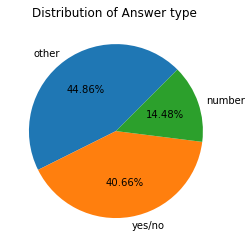

In [56]:
# plot pie chart of dataframe of answer_type and its counts
plt.pie(list(answer_type_df['answer%']), labels=list(answer_type_df.index), autopct='%1.2f%%', startangle=45)
plt.title('Distribution of Answer type ')
plt.show()

* 40.66% of answers have a "yes/no" answer_type which means these answers have only two categories "yes" or "no".
* 14.48% of answers have a "number" answer_type which means these answers are from the numeric/digit category.
* 44.86% of answers have "other" answer_type which means these answers contain simple text words.

In [57]:
# create dataframe of unique answers and its counts in decending order of answer_count
count = {}
for i in answer_preprocessed:
    count[i] = count.get(i, 0) + 1
    
answer_df = pd.DataFrame(list(count.items()),columns=["answer","answer_count"])
answer_df["answer%"] = answer_df["answer_count"]/len(answer_preprocessed)*100  
answer_df = answer_df.sort_values(by='answer_count',ascending=False)
answer_df.head(10)

,answer,answer_count,answer%
3,yes,14314,23.856667
7,no,10143,16.905000
15,2,3496,5.826667
16,1,1934,3.223333
32,red,1506,2.510000
20,3,1373,2.288333
107,white,789,1.315000
33,yellow,603,1.005000
34,blue,603,1.005000
70,4,599,0.998333


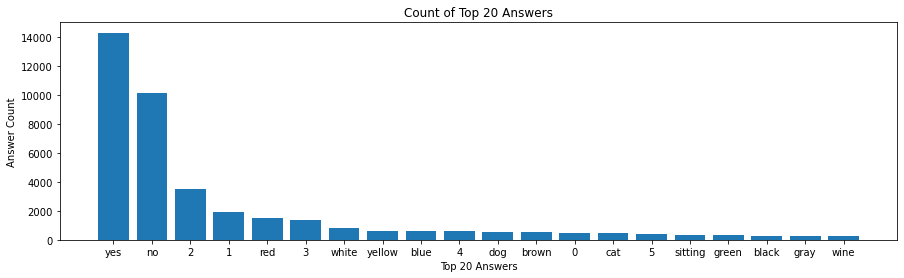

In [58]:
# Plot top 20 answers and its count from above dataframe
plt.figure(figsize=(15,4))
plt.bar(list(answer_df['answer'])[:20], list(answer_df['answer_count'])[:20])
plt.title('Count of Top 20 Answers')
plt.xlabel('Top 20 Answers')
plt.ylabel('Answer Count')
plt.xticks(list(answer_df['answer'])[:20])
plt.show()

**Observations:**
* A very large number of the answers are "yes" and "no".
* In number answer_type, 2,1,3,4,0,5 these numbers have more counts than other numbers.
* In other answer_type, color names have more counts which means most questions are may be color related.

In [59]:
print(f"Top 1000 answers coverd {round(sum(list(answer_df['answer%'][:1000])),2)}% of datapoints")
print(f"Top 2000 answers coverd {round(sum(list(answer_df['answer%'][:2000])),2)}% of datapoints")
print(f"Top 3000 answers coverd {round(sum(list(answer_df['answer%'][:3000])),2)}% of datapoints")

Top 1000 answers coverd 97.46% of datapoints
Top 2000 answers coverd 99.15% of datapoints
Top 3000 answers coverd 100.0% of datapoints


* We will consider the top 1000 or 2000 answers as class labels, and consider this problem as multi-class classification problem.

**Questions & Answers who have answer length >= 6**

In [74]:
# Questions & Answers who have answer length >= 6
for i,a in enumerate(answer_preprocessed):
    if len(a.split()) >= 6:
        print('Que:',question_preprocessed[i])
        print('Ans:',a)
        print('Length of Ans:',len(a.split()))
        print("-"*50)

Que: why is the little boy alone
Ans: his parents are further behind him
Length of Ans: 6
--------------------------------------------------
Que: what is the boy on the right thinking about the old lady
Ans: she should let him go outside
Length of Ans: 6
--------------------------------------------------
Que: why is the moon out during the daytime
Ans: it is getting close to night
Length of Ans: 6
--------------------------------------------------
Que: why is there no sofa in this room
Ans: owner has not buy it yet
Length of Ans: 6
--------------------------------------------------
Que: why is the horse toy placed against the wall away from the other toys
Ans: it is not being played with
Length of Ans: 6
--------------------------------------------------
Que: name the things you see on the blanket
Ans: basket cup and loaf of bread
Length of Ans: 6
--------------------------------------------------
Que: why is one man upset
Ans: trying to study while other guy is watching tv
Length of A

**Observations:**
* The answers who have a length of 6 or more than 6 words are mostly answers of 'what' and 'why' questions.
* These 'what' and 'why' questions are about giving description or reasons from an image.

## 3.4 EDA - Question & Answer

In [62]:
# Create dataframe of first two words of question and its most common answers
question_df = pd.DataFrame(question_preprocessed,columns=["question"])
question_split_df = question_df['question'].str.split(" ", expand = True)
question_answer_df = question_split_df.iloc[:,:-19]
question_answer_df['answer'] = answer

def que_ans_analysis2(word_1,word_2):
    word_1_2_df = question_answer_df[(question_answer_df[0] == word_1) & (question_answer_df[1] == word_2)]
    word_1_2_count = (word_1_2_df.groupby(['answer']).count()[0]).to_frame()
    word_1_2_count = word_1_2_count.sort_values(by=0,ascending=False)
    
    plt.figure(figsize=(20,4))
    plt.bar(list(word_1_2_count.index)[:20], list(word_1_2_count[0])[:20])
    plt.title('Count of Top 20 Answers of "'+word_1+' '+word_2+'" questions')
    plt.xlabel('Top 20 Answers of "'+word_1+' '+word_2+'" questions')
    plt.ylabel('Count')
    plt.xticks(list(word_1_2_count.index)[:20])
    plt.show()

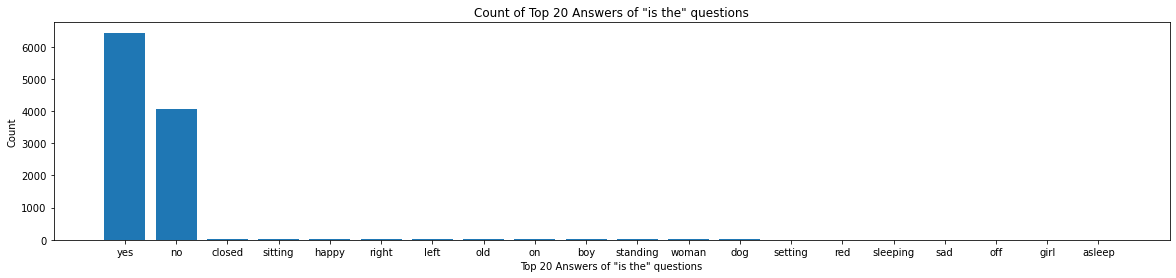

In [63]:
que_ans_analysis2("is","the")

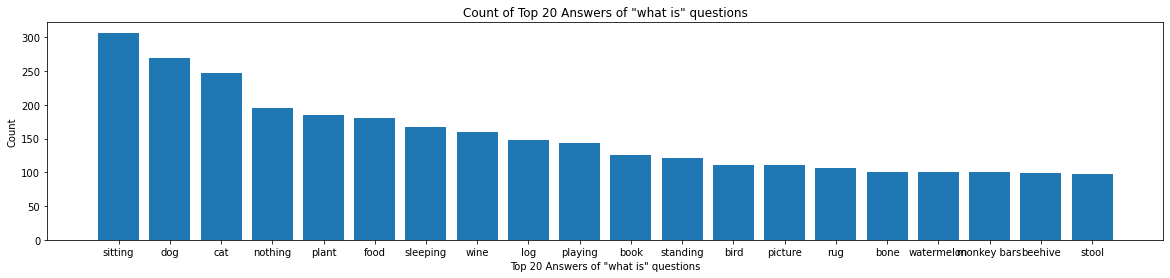

In [64]:
que_ans_analysis2("what","is")

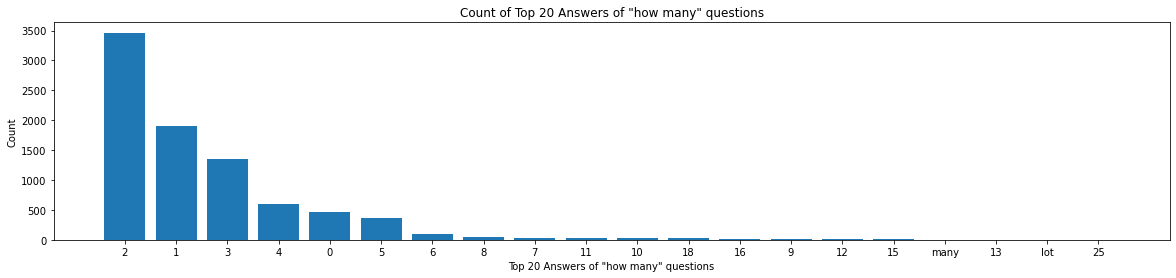

In [65]:
que_ans_analysis2("how","many")

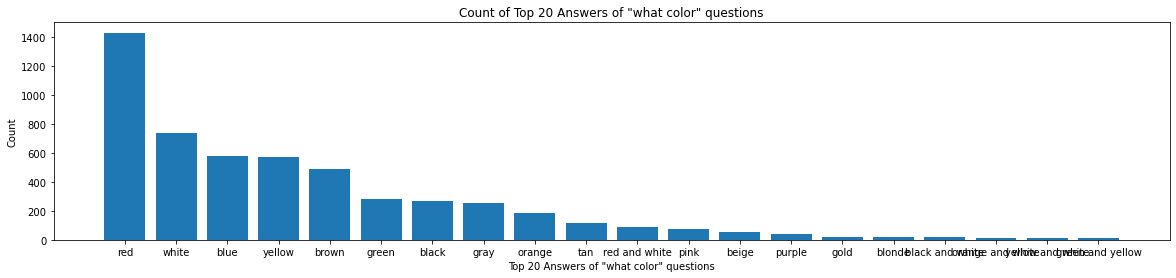

In [66]:
que_ans_analysis2("what","color")

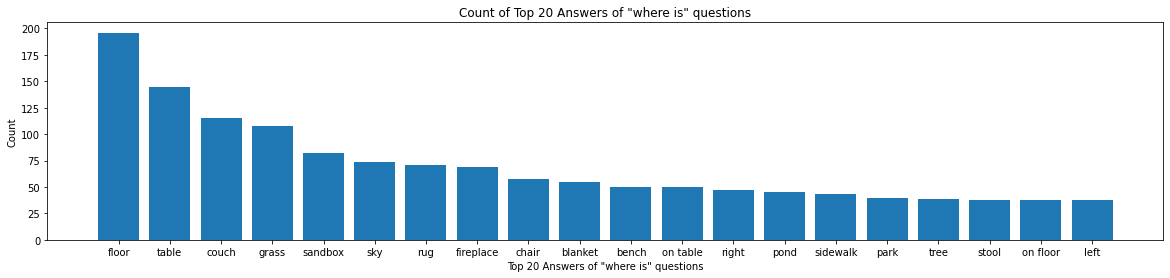

In [67]:
que_ans_analysis2("where","is")

**Observations:**
* The questions that start with "What" have the most answers color names, sports names, activity names, object names, or food names.
* The questions that start with "how" have the most answers numbers or quantifier words like many, few, more, some, all, etc.
* The questions that start with "is", have a very large number of answers only "yes" or "no".
* The questions that start with "where", have the most answers object, place or position names.

# 4. Business constraints & Performance Metric

VQA(Visual Question Answering) is a Natural Language Processing and Computer Vision problem, and It combines problems from multiple areas of computer vision and NLP.
VQA model predicts short text answers to a question which is about a real or abstract image. VQA model's outcome is a short and simple text answer of asked question.
We consider this problem as a K-class classification problem, where K is the number of a fixed set of answer types in the dataset. We will use categorical cross-entropy as a loss function.

Business constraints are:
* Model must be able to do object detection, classification of the scene, and commonsense reasoning to answer a specific question about an image.
* Model also be able to find reason about their relationship with each other object and scene. 
* Quality of answers is important and no strict latency requirement but we can try to reduce latency.
* The probability of a question belonging to each answer class is needed

Total three types of datasets are given. 
1. MSCOCO
2. Binary Abstract
3. Abstract

**Multi-class Log-loss:**

In all three datasets, most answers(89.32%) are single and repeated text words. We can consider the top 1000(k) answers as the class label, convert them into one hot encoded class vector, and compare predicted and ground truth probability to check performance. Multi-class Log-loss is the best performance metric to compare predicted and ground truth probabilities.

Why Multi-class Log-loss?

* Log-loss is a probabilistic classification metric that uses the predicted probabilities scores.
* In classification tasks, most models give output as the probability of each class, so log-loss is best to compare different classification models.
* Log-loss does not only evaluate the performance based on correct predictions but also penalizes wrong predictions according to the predicted probabilities.
* Log-loss is more certain at the prediction and it is also robust to the imbalanced data set.
* The lower the log-loss value, the better the predictions of the model.

**BLEU Score:**

* To match predicted and ground truth text we can use the BLEU score as an evaluation metric. 
* The perfect match of the BLEU Score is 1.0 and a perfect mismatch is 0.0 BLEU score. 
* BLEU score compares only words it can not compare the sequence of words.
* In this classification problem, We can use BLEU Score to check whether predicted and ground truth texts are exactly same or not, if both texts are exactly same then the accuracy is 1 otherwise 0, and take an average of accuracy.